## Contracting a Tensor network
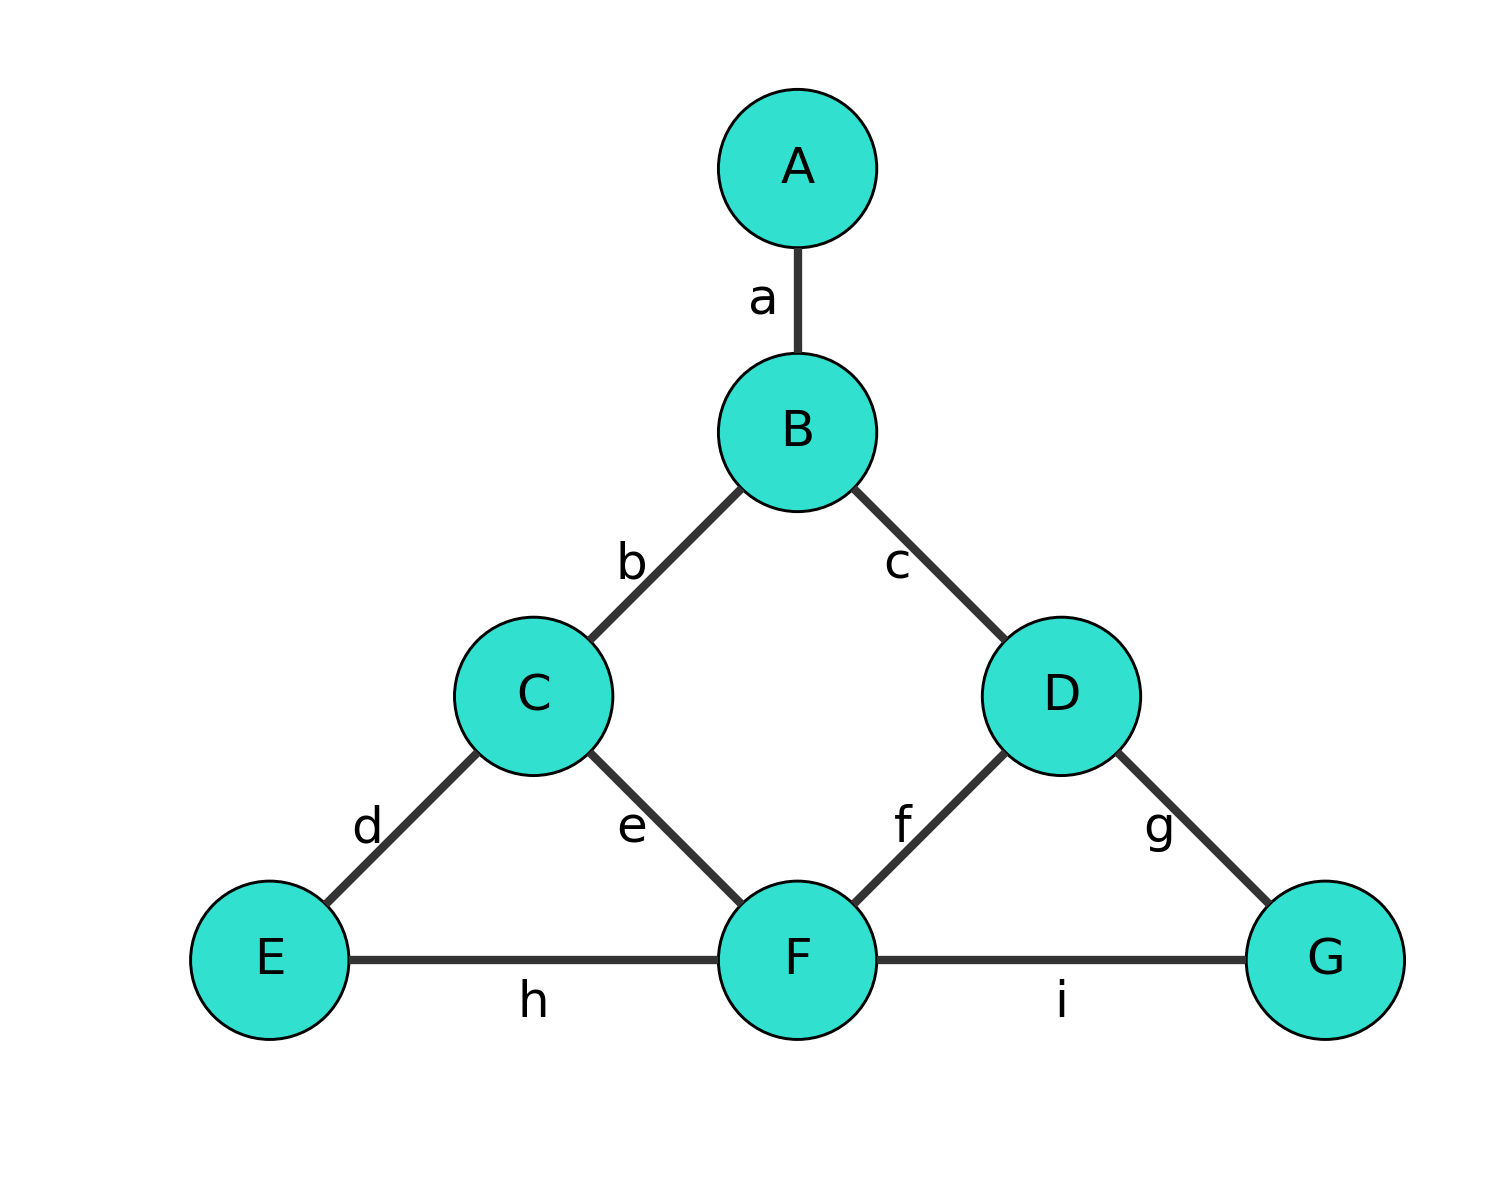

In [1]:
using TensorOperations, Test

In [2]:
dims = [1, 3, 3, 3, 2, 4, 2]
A, B, C, D, E, F, G = map(nd->randn(fill(20, nd)...), dims)

@tensor begin
    Y1[b, c] := A[a] * B[a,b,c]         # N^3
    Y2[c,d,e] := Y1[b,c] * C[b,d,e]        # N^4
    Y3[d,e,f,g] := Y2[c,d,e] * D[c,f,g]       # N^5
    Y4[d,g,h,i] := Y3[d,e,f,g] * F[e,f,h,i]       # N^6
    Y5[g,i] := Y4[d,g,h,i] * E[d,h]       # N^4
    Y5[g,i] * G[g,i]        # N^2
end

-134597.80512909993

# Mapping a QFT circuit to a TN

<img src="images/_qft.png" width="800">

## Hadamard Gate
<img src="images/hadamard.png" width="100">

In [4]:
using Yao # the quantum circuit simulator in Julia
mat(H)

2×2 Array{Complex{Float64},2}:
 0.707107+0.0im   0.707107+0.0im
 0.707107+0.0im  -0.707107+0.0im

## Control-Phase Gate
<img src="images/control-R.png" width="90">

control-Tensor (bottom): $\delta_{ijk}$

Phase-Tensor (bottom): ${\rm R_k}_{ljm} = \begin{cases}\delta_{lm} & j=0,\\ \rm{diag}(1, e^{i\frac{2\pi}{2^{\rm k}}}) & j=1.\end{cases}$

In [5]:
CRk(i::Int, j::Int, k::Int) = control([i, ], j=>shift(2π/(1<<k)))
mat(CRk(2,1,2)(2))

4×4 LinearAlgebra.Diagonal{Complex{Float64},Array{Complex{Float64},1}}:
 1.0+0.0im      ⋅          ⋅                  ⋅    
     ⋅      1.0+0.0im      ⋅                  ⋅    
     ⋅          ⋅      1.0+0.0im              ⋅    
     ⋅          ⋅          ⋅      6.12323e-17+1.0im

In [31]:
function Rk(k)
    y = zeros(ComplexF64, 2,2,2)
    y[:,1,:] = δ(2,2)
    y[:,2,:] = [1 0; 0 exp(2im*π/2^k)]
    y
end

function δ(dims...)
    y = zeros(dims)
    for i=1:min(dims...)
        y[fill(i, length(dims))...] = 1
    end
    y
end

@test reshape(einsum(((1,2,3), (4,2,5)), (δ(2,2,2), Rk(2)), (1,4,3,5)), 4, 4) ≈ mat(CRk(2,1,2)(2))

Test Passed

or equivalently

<img src="images/chc.png" width="100">
with
${\rm H_k} = \left(\begin{array}(1 & 1 \\ 1 & e^{i\frac{2\pi}{2^{\rm k}}}\end{array}\right)$

# Obtaining the result directly

In [10]:
CRot(n::Int, i::Int) = chain(n, i==j ? kron(i=>H) : CRk(j, i, j-i+1) for j = i:n)
QFTCircuit(n::Int) = chain(n, CRot(n, i) for i = 1:n)

qft = QFTCircuit(5)

nqubits: 5
chain
├─ chain
│  ├─ kron
│  │  └─ 1=>H gate
│  ├─ control(2)
│  │  └─ (1,) shift(1.5707963267948966)
│  ├─ control(3)
│  │  └─ (1,) shift(0.7853981633974483)
│  ├─ control(4)
│  │  └─ (1,) shift(0.39269908169872414)
│  └─ control(5)
│     └─ (1,) shift(0.19634954084936207)
├─ chain
│  ├─ kron
│  │  └─ 2=>H gate
│  ├─ control(3)
│  │  └─ (2,) shift(1.5707963267948966)
│  ├─ control(4)
│  │  └─ (2,) shift(0.7853981633974483)
│  └─ control(5)
│     └─ (2,) shift(0.39269908169872414)
├─ chain
│  ├─ kron
│  │  └─ 3=>H gate
│  ├─ control(4)
│  │  └─ (3,) shift(1.5707963267948966)
│  └─ control(5)
│     └─ (3,) shift(0.7853981633974483)
├─ chain
│  ├─ kron
│  │  └─ 4=>H gate
│  └─ control(5)
│     └─ (4,) shift(1.5707963267948966)
└─ chain
   └─ kron
      └─ 5=>H gate


In [11]:
# get the result using a vector based quantum simulator
reg = rand_state(5);
res = copy(reg) |> qft
ψ = dropdims(reg |> hypercubic, dims=6)

2×2×2×2×2 Array{Complex{Float64},5}:
[:, :, 1, 1, 1] =
 -0.0457539-0.0279078im  -0.0258173-0.0850063im
   0.267996-0.021331im   -0.0668975-0.0545512im

[:, :, 2, 1, 1] =
 -0.0850165+0.278302im   0.110189+0.00674637im
 -0.0515415+0.033659im  -0.128803+0.0606474im 

[:, :, 1, 2, 1] =
  -0.140584-0.0346731im  0.0127278+0.147432im
 -0.0808304-0.134305im   0.0635109+0.198012im

[:, :, 2, 2, 1] =
  0.0204942-0.0109959im   0.0433917-0.0255899im
 -0.0193382+0.144685im   -0.0700042-0.0839113im

[:, :, 1, 1, 2] =
 0.0254895+0.0868542im   0.165825-0.203697im
  0.241582+0.110676im   -0.180261+0.374007im

[:, :, 2, 1, 2] =
  0.0156797-0.165787im     0.22233+0.027176im 
 -0.0291028-0.0347641im  0.0133834-0.0410439im

[:, :, 1, 2, 2] =
  -0.105423-0.00246679im    -0.14226-0.0574782im
 -0.0029446-0.191807im    -0.0165242-0.181424im 

[:, :, 2, 2, 2] =
 0.167395+0.16858im     -0.0241124+0.097566im
 0.157668-0.00385642im     0.10196+0.182011im

# The (generalized) tensor network approach
### 1. labeling legs in a quantum circuit
* If a gate is diagonal, or a control gate, do not change the label, e.g. CPHASE gate in this example,
* otherwise a asign a new label (like `H` gate in this example)


<img src="images/qftslices.png" width="1000"/>

### 2. these labels are nodes in a probability graph

<img src="images/qfttn.png" width="350"/>

We can define a elimination order for this graph, or map it to a tensor network with pairwise contraction only.

# Incidence List

In [12]:
ilist = [(1,6), (2,6), (2,7), (3,6),(3,7), (3,8), (4,6),(4,7),(4,8),(4,9), (5,6),(5,7),(5,8),(5,9),(5,10)]

15-element Array{Tuple{Int64,Int64},1}:
 (1, 6) 
 (2, 6) 
 (2, 7) 
 (3, 6) 
 (3, 7) 
 (3, 8) 
 (4, 6) 
 (4, 7) 
 (4, 8) 
 (4, 9) 
 (5, 6) 
 (5, 7) 
 (5, 8) 
 (5, 9) 
 (5, 10)

In [13]:
Hk(k::Int) = [1 1; 1 exp(2im*π/(1<<k))]
H1 = mat(H)
H2 = Hk(2)
H3 = Hk(3)
H4 = Hk(4)
H5 = Hk(5);

In [14]:
using OMEinsum
out_ein = einsum(((1,2,3,4,5), ilist...), (ψ,H1,H2,H1,H3,H2,H1,H4,H3,H2,H1,H5,H4,H3,H2,H1), (6,7,8,9,10))
statevec(res) ≈ vec(out_ein)

true

In [36]:
using TensorOperations

In [64]:
Δ(dim::Int) = δ(fill(2,dim)...)
δ3 = Δ(3);
δ4 = Δ(4);
δ5 = Δ(5);
δ6 = Δ(6);
@tensoropt begin
    out[f,g,h,i,j] :=
    ψ[a,b,c,d,e] * 
    H1[a,f1] * H2[f2,b1] * H3[f3,c1] * H4[f4,d1] * H5[f5,e1] *
    H1[b2,g1] * H2[g2,c2] * H3[g3,d2] * H4[g4,e2] *
    H1[c3,h1] * H2[h2,d3] * H3[h3,e3] *
    H1[d4,i1] * H2[i2,e4] *
    H1[e5,j] *
    δ3[b2,b1,b] *
    δ4[c3,c2,c1,c] *
    δ5[d4,d3,d2,d1,d] *
    δ6[e5,e4,e3,e2,e1,e] *
    δ3[i2,i1,i] *
    δ4[h3,h2,h1,h] *
    δ5[g4,g3,g2,g1,g] *
    δ6[f5,f4,f3,f2,f1,f]
end;

In [63]:
statevec(res) ≈ vec(out)

true